In [1]:
import openmc
import matplotlib.pyplot as plt
import numpy as np
import openmc_source_plotter
import neutronics_material_maker as nmm
import openmc_source_plotter

In [2]:


#Lupin materials

#lead casing
lead = openmc.Material(name='lead')
lead.add_element('Pb', 1, 'ao')
lead.set_density('g/cm3', 11.34)
#aluminium shell
al = openmc.Material(name='aluminium')
al.add_element('Al', 1, 'ao')
al.set_density('g/cm3', 2.7)
al.add_s_alpha_beta("c_Al27")
#cadmium
cadmium = openmc.Material(name='cadmium')
cadmium.add_element('Cd', 1, 'ao')
cadmium.set_density('g/cm3', 4.047)
#BF3
bf3 = nmm.Material.from_library('Boron Fluoride (BF3)', temperature=294, pressure=26664).openmc_material
#bf3.set_density("atom/b-cm",7.3e-4)
#polyethylene
polyethylene = openmc.Material(name='polyethylene')
polyethylene.add_elements_from_formula('C2H4')
polyethylene.set_density('g/cm3',0.93)
polyethylene.add_s_alpha_beta('c_H_in_CH2')


materials = openmc.Materials([lead, al, cadmium, bf3, polyethylene])
materials.export_to_xml()



In [3]:
#geometry dimensions
cylinder_radius = 5.4
detector_radius = 2
active_radius = 2.54/2
outer_cylinder_radius = 12.5
lead_thickness = 0.15
shielding_thickness = 0.15

lead_height = 14.1
b_detector_height = 4.7
#active_detector_height = 15
cylinder_height = 29.7
big_cd_height = 5
small_cd_height = 2.5

cd_thickness = 0.15
cd_gap = 2.425

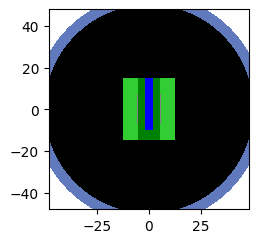

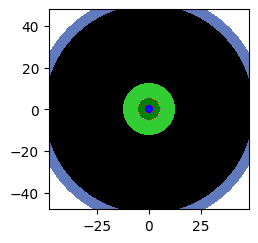

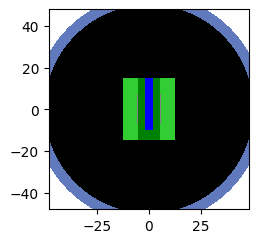

In [4]:
#geometry model

detector = openmc.ZCylinder(r=detector_radius)
#active_detector = openmc.ZCylinder(r=active_radius)
shielding = openmc.ZCylinder(r=detector_radius + shielding_thickness)
inner_cylinder = openmc.ZCylinder(r=cylinder_radius)
lead_plate = openmc.ZCylinder(r=cylinder_radius + lead_thickness)
cd_cylinder = openmc.ZCylinder(r=cylinder_radius - (cd_thickness))
outer_cylinder = openmc.ZCylinder(r=outer_cylinder_radius)
source_sphere = openmc.Sphere(r=50)
outer_void = openmc.Sphere(r=55, boundary_type='vacuum')

top_cylinder = openmc.ZPlane(z0=0.5*cylinder_height)
bottom_cylinder = openmc.ZPlane(z0=-0.5*cylinder_height)
bottom_detector = openmc.ZPlane(z0=-0.5*cylinder_height + b_detector_height)
bottom_shielding = openmc.ZPlane(z0=-0.5*cylinder_height + b_detector_height-shielding_thickness)
top_lead = openmc.ZPlane(z0=0.5*lead_height)
bottom_lead = openmc.ZPlane(z0=-0.5*lead_height)
top_wall_cylinder = openmc.ZPlane(z0=0.5*cylinder_height+0.1)

#top_active_detector = openmc.ZPlane(z0=0.5*(cylinder_height-active_detector_height))
#bottom_active_detector = openmc.ZPlane(z0=0.5*(-cylinder_height+active_detector_height))

cd_cylinder_region = +cd_cylinder & -inner_cylinder 
cd_bottom_1 = openmc.ZPlane(0.5*cylinder_height-big_cd_height)
cd_top_2 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap)
cd_bottom_2 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap-small_cd_height)
cd_top_3 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap-small_cd_height-cd_gap)
cd_bottom_3 = openmc.ZPlane(0.5*cylinder_height-big_cd_height-cd_gap-small_cd_height-cd_gap-big_cd_height)
cd_top_4 = openmc.ZPlane(0.5*-cylinder_height+big_cd_height+cd_gap+small_cd_height)
cd_bottom_4 = openmc.ZPlane(0.5*-cylinder_height+big_cd_height+cd_gap)
cd_top_5 = openmc.ZPlane(0.5*-cylinder_height+big_cd_height)

cd_1 = cd_cylinder_region & -top_cylinder & +cd_bottom_1
cd_2 = cd_cylinder_region & -cd_top_2 & +cd_bottom_2
cd_3 = cd_cylinder_region & -cd_top_3 & +cd_bottom_3
cd_4 = cd_cylinder_region & -cd_top_4 & +cd_bottom_4
cd_5 = cd_cylinder_region & -cd_top_5 & +bottom_cylinder
cd_region = cd_1 | cd_2 | cd_3 | cd_4 | cd_5

#active_detector_region = -active_detector & -top_active_detector & +bottom_active_detector
detector_region = -detector & -top_cylinder & +bottom_detector 
shielding_region = (-shielding & -top_cylinder & +bottom_shielding & +detector) | ( -detector & +bottom_shielding & -bottom_detector)

inner_polyethylene_region = ((-inner_cylinder & + shielding & -top_cylinder & +bottom_cylinder) | (-shielding & -bottom_shielding & +bottom_cylinder)) & ~cd_region

lead_region = -lead_plate & -top_lead & +bottom_lead & + inner_cylinder
outer_polyethylene_region = (-outer_cylinder & -top_cylinder & +bottom_cylinder & ~lead_region & +inner_cylinder ) | (-top_wall_cylinder & +top_cylinder & - outer_cylinder)
sphere_region = (-source_sphere & +outer_cylinder) | (+top_wall_cylinder & -source_sphere) | (-bottom_cylinder & -source_sphere)
outer_void_region = +source_sphere & -outer_void

#active_detector_cell = openmc.Cell(region=active_detector_region, fill=bf3)
detector_cell = openmc.Cell(region=detector_region, fill=bf3)
shielding_cell = openmc.Cell(region=shielding_region, fill=al)
inner_polyethylene_cell = openmc.Cell(region=inner_polyethylene_region, fill=polyethylene)
lead_cell = openmc.Cell(region=lead_region, fill=lead)
cd_cell = openmc.Cell(region =cd_region, fill = cadmium)
outer_polyethylene_cell = openmc.Cell(region=outer_polyethylene_region, fill=polyethylene)
source_cell = openmc.Cell(region=sphere_region)
outer_void_cell = openmc.Cell(region=outer_void_region)

universe = openmc.universe = openmc.Universe(cells=[ detector_cell, shielding_cell, inner_polyethylene_cell, lead_cell, cd_cell, outer_polyethylene_cell, source_cell, outer_void_cell])


x,y = 96,96
color_assignment = {detector_cell : 'blue',
                    shielding_cell : 'red',
                    inner_polyethylene_cell : 'green',
                    cd_cell : 'orange',
                    lead_cell : 'grey',
                    outer_polyethylene_cell :'limegreen',
                   source_cell : 'black'}
plt.show(universe.plot(width=(x, y), basis='xz',  colors=color_assignment))
plt.show(universe.plot(width=(x, y), basis='xy',  colors=color_assignment))
plt.show(universe.plot(width=(x, y), basis='yz',  colors=color_assignment))

geometry = openmc.Geometry(universe)
geometry.export_to_xml()

In [6]:
from math import pi, cos
#now create the source
#spherical source enclosing the detector
def sett_func(source_energy):
    
    sett = openmc.Settings()
    sett.particles = 1000000
    sett.batches = 5
    sett.inactive = 0
    sett.run_mode = 'fixed source'

    sphere_source = openmc.Source()

    phi_angle = openmc.stats.Uniform(a=0., b= 2*3.14159265359)
    costheta_angle = openmc.stats.Uniform(a=-1, b=1)
    source_distance = openmc.stats.Discrete([-0.5, 0.5], [0.5,0.5]) #m away from the lupin detector

    sphere_source.particle = 'neutron'
    sphere_source.energy = openmc.stats.Discrete([source_energy], [1])
    aperture = 16.67
    mu = openmc.stats.Uniform(cos(aperture/2), 1.0)
    phi = openmc.stats.Uniform(0.0, 2*pi)
    angle = openmc.stats.PolarAzimuthal(mu, phi, reference_uvw=(-1., 0., 0.))
    sphere_source.angle = angle
    sphere_source.space = openmc.stats.Point((50, 0, 0))
    sett.source = sphere_source
    return sett



In [87]:
#create 3d mesh between set coordinates
cd_bounds = sorted(np.array([top_cylinder.z0 ,cd_bottom_1.z0, cd_top_2.z0,cd_bottom_2.z0, cd_top_3.z0, cd_bottom_3.z0, cd_top_4.z0, cd_bottom_4.z0, cd_top_5.z0, bottom_cylinder.z0]))

mesh = openmc.CylindricalMesh(mesh_id=1, name="detector_mesh")
mesh.r_grid = np.array([0, 0.5,1, 1.5, detector_radius])
mesh.phi_grid = np.array([0, 2*pi])
mesh.z_grid = cd_bounds[:-1]
mesh_filter = openmc.MeshFilter(mesh)


/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)


In [88]:

energy = 1e2
energy_filter = openmc.EnergyFilter([0, 2e2])
#settings
sett = sett_func(energy)

#tallies
tallies = openmc.Tallies()
#neutron_particle_filter = openmc.ParticleFilter(['neutron'])
tally = openmc.Tally(name='tally')
tally.scores =['flux']
tally.filters = [mesh_filter]
tallies.append(tally)



In [89]:
model = openmc.model.Model(geometry, materials, sett, tallies)
# remove old files and runs OpenMC
!rm *.h5
results_filename = model.run()
results = openmc.StatePoint(results_filename)
flux_tally = results.get_tally(name="tally")

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [90]:
df = flux_tally.get_pandas_dataframe()
df

mesh 1       nuclide score     mean std. dev.
        x  y  z                                 
0       1  1  1   total  flux 1.34e-06  5.80e-07
1       2  1  1   total  flux 7.50e-06  2.83e-06
2       3  1  1   total  flux 9.82e-06  2.02e-06
3       4  1  1   total  flux 1.49e-05  3.38e-06
4       1  1  2   total  flux 3.44e-06  6.34e-07
5       2  1  2   total  flux 8.04e-06  1.69e-06
6       3  1  2   total  flux 1.69e-05  2.84e-06
7       4  1  2   total  flux 1.81e-05  2.60e-06
8       1  1  3   total  flux 2.52e-06  7.65e-07
9       2  1  3   total  flux 7.86e-06  1.50e-06
10      3  1  3   total  flux 1.42e-05  1.92e-06
11      4  1  3   total  flux 2.13e-05  3.93e-06
12      1  1  4   total  flux 2.99e-06  5.10e-07
13      2  1  4   total  flux 7.52e-06  2.12e-06
14      3  1  4   total  flux 1.43e-05  2.48e-06
15      4  1  4   total  flux 1.92e-05  2.72e-06
16      1  1  5   total  flux 5.05e-06  1.52e-06
17      2  1  5   total  flux 1.16e-05  2.36e-06
18      3  1  5   total  flux 2.04e-05  4.91e-06
19      4  1  5   total  flux 2.93e-05  3.62e-06
20      1  1  6   total  flux 1.74e-06  4.95e-07
21      2  1  6   total  flux 5.41e-06  1.38e-06
22      3  1  6   total  flux 9.45e-06  2.08e-06
23      4  1  6   total  flux 1.21e-05  2.58e-06
24      1  1  7   total  flux 1.81e-06  3.23e-07
25      2  1  7   total  flux 3.33e-06  9.34e-07
26      3  1  7   total  flux 7.86e-06  1.59e-06
27      4  1  7   total  flux 1.08e-05  2.40e-06
28      1  1  8   total  flux 7.42e-07  4.94e-07
29      2  1  8   total  flux 2.43e-06  4.88e-07
30      3  1  8   total  flux 5.43e-06  1.01e-06
31      4  1  8   total  flux 7.28e-06  2.19e-06

In [91]:
mean = df['mean'].values.reshape((8,4))
mean = np.flip(mean)
mean

array([[7.27832207e-06, 5.43330032e-06, 2.42525800e-06, 7.42176904e-07],
       [1.08255823e-05, 7.85781387e-06, 3.32777943e-06, 1.80990914e-06],
       [1.20642728e-05, 9.44892845e-06, 5.40562596e-06, 1.74379994e-06],
       [2.92882255e-05, 2.04432258e-05, 1.15526589e-05, 5.04760714e-06],
       [1.92437193e-05, 1.43165024e-05, 7.51807037e-06, 2.98595771e-06],
       [2.13202938e-05, 1.42342771e-05, 7.86039865e-06, 2.51787402e-06],
       [1.80750621e-05, 1.68553681e-05, 8.04407061e-06, 3.43757117e-06],
       [1.49120909e-05, 9.82475377e-06, 7.50126516e-06, 1.34376535e-06]])

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


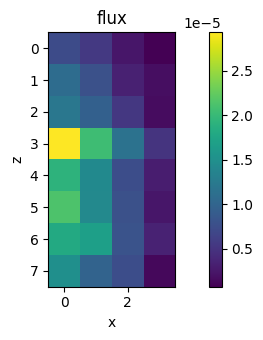

In [92]:
plt.imshow(mean, interpolation='nearest')
plt.title('flux')
plt.xlabel('x')
plt.ylabel('z')
plt.colorbar()